In [53]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [54]:
# Load the dataset
file_path = "E:\竞赛\服创赛-A08\data\process_data.csv"
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop(columns=['RES'])  # Assuming 'RES' is the target column
y = data['RES']

In [55]:
# Imputing missing values with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardizing the imputed data
scaler = StandardScaler()
X_imputed_scaled = scaler.fit_transform(X_imputed)

In [56]:
# Applying PCA
pca = PCA()
pca.fit(X_imputed_scaled)
X_pca_imputed = pca.transform(X_imputed_scaled)

In [57]:
# Calculating the explained variance ratio of the PCA components
explained_variance_imputed = pca.explained_variance_ratio_


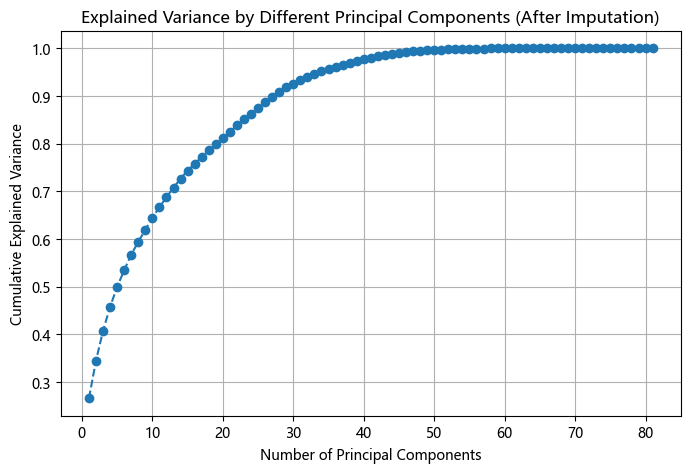

In [58]:
# Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_imputed) + 1), explained_variance_imputed.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Different Principal Components (After Imputation)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [59]:
# 应用 PCA 以保留95%的方差
pca = PCA(n_components=0.95)
X_pca_95 = pca.fit_transform(X_imputed_scaled)

In [60]:
# Extracting the PCA components
pca_components = pca.components_

# Displaying top contributing features for each component
for i, component in enumerate(pca_components):
    component_df = pd.DataFrame(component, index=X.columns, columns=['Coefficient'])
    top_feature = component_df.abs().nlargest(1, 'Coefficient').index[0]
    print(f"Principal Component {i+1}'s top contributing feature: {top_feature}")

Principal Component 1's top contributing feature: 本次审批金额_SUM
Principal Component 2's top contributing feature: 月就诊医院数_MAX
Principal Component 3's top contributing feature: 治疗费用在总金额占比
Principal Component 4's top contributing feature: 检查费发生金额_SUM
Principal Component 5's top contributing feature: 民政救助补助_SUM
Principal Component 6's top contributing feature: 检查费申报金额_SUM
Principal Component 7's top contributing feature: 医用材料发生金额_SUM
Principal Component 8's top contributing feature: 床位费发生金额_SUM
Principal Component 9's top contributing feature: 手术费申报金额_SUM
Principal Component 10's top contributing feature: 床位费申报金额_SUM
Principal Component 11's top contributing feature: 个人支付的药品占比
Principal Component 12's top contributing feature: BZ_城乡优抚
Principal Component 13's top contributing feature: 个人支付治疗费用占比
Principal Component 14's top contributing feature: 个人支付治疗费用占比
Principal Component 15's top contributing feature: 个人支付检查费用占比
Principal Component 16's top contributing feature: 公务员医疗补助基金支付金额_SUM
Princip

In [61]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import os
import joblib

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

In [62]:
data = pd.DataFrame(X_pca_95, columns=[f'PC{i+1}' for i in range(X_pca_95.shape[1])])

# 删除含有NaN值的行
data.dropna(inplace=True)

data['RES'] = y.values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('RES', axis=1), data['RES'], test_size=0.3, random_state=42)

In [64]:
X_train.shape

(11200, 34)

In [65]:
def strategy_3(X, y, model, test_size=0.3, random_state=123, smote_random_state=42, k_neighbors=5):
    """
    使用SMOTE策略训练模型，并返回分类报告。

    参数:
    - X: DataFrame, 特征数据集。
    - y: Series, 目标变量数据集。
    - model: 机器学习模型。
    - test_size: float, 测试集占比。
    - random_state: int, train_test_split的随机状态。
    - smote_random_state: int, SMOTE的随机状态。
    - k_neighbors: int, SMOTE中的最近邻数量。

    返回:
    - 分类报告。
    """
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(data.drop('RES', axis=1), data['RES'], test_size=0.3, random_state=42)

    # 应用SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=smote_random_state, k_neighbors=k_neighbors)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # 训练模型
    model.fit(X_train_smote, y_train_smote)

    # 进行预测
    y_pred = model.predict(X_test)

    # 生成分类报告
    classification_rep = classification_report(y_test, y_pred)

    return classification_rep,model

In [66]:
def strategy_4(model, X_test, y_test, thresholds):

    classification_reports = {}
    for thresh in thresholds:
        # 以概率形式获取预测结果
        y_probs = model.predict_proba(X_test)[:, 1]  # 获取正类的概率
        # 应用阈值
        y_pred_thresh = np.where(y_probs > thresh, 1, 0)
        # 生成并存储分类报告
        classification_reports[thresh] = classification_report(y_test, y_pred_thresh)

    return classification_reports

In [67]:
def load_and_split_data(input_data, target_column='RES', test_size=0.3, random_state=42):
    # Load the dataset if a file path is provided, else use the DataFrame directly
    if isinstance(input_data, str):
        _, file_extension = os.path.splitext(input_data)
        if file_extension.lower() == '.csv':
            data = pd.read_csv(input_data)
        elif file_extension.lower() == '.xlsx':
            data = pd.read_excel(input_data)
        else:
            raise ValueError("Unsupported file format. Only CSV and Excel files are supported.")
    elif isinstance(input_data, pd.DataFrame):
        data = input_data
    else:
        raise ValueError("Input data should be a file path or a DataFrame.")

    # Separate features and target
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Handle class imbalance
    data_majority = data[data[target_column] == 0]
    data_minority = data[data[target_column] == 1]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data.drop('RES', axis=1), data['RES'], test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test, X, y, data_majority, data_minority

In [68]:
# 分离类别
data_majority = data[data.RES == 0]
data_minority = data[data.RES == 1]

In [69]:
model = RandomForestClassifier(
    n_estimators=100,
    #max_depth=5,
    random_state=123,
    n_jobs=-1
)

In [70]:
# 应用 strategy_3
classification_reports,model = strategy_3(X, y, model, test_size=0.3, random_state=123, smote_random_state=42, k_neighbors=5)

# 打印分类报告

print(classification_reports)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4563
           1       0.42      0.44      0.43       237

    accuracy                           0.94      4800
   macro avg       0.70      0.70      0.70      4800
weighted avg       0.94      0.94      0.94      4800



In [71]:
thresholds = [ 0.5,0.55, 0.6,0.65, 0.7,0.75]
reports = strategy_4(model,X_test, y_test, thresholds)

# 输出每个阈值下的分类报告
for thresh, report in reports.items():
    print(f"Threshold: {thresh}\n", report)

Threshold: 0.5
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4563
           1       0.42      0.44      0.43       237

    accuracy                           0.94      4800
   macro avg       0.70      0.70      0.70      4800
weighted avg       0.94      0.94      0.94      4800

Threshold: 0.55
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      4563
           1       0.49      0.40      0.44       237

    accuracy                           0.95      4800
   macro avg       0.73      0.69      0.71      4800
weighted avg       0.95      0.95      0.95      4800

Threshold: 0.6
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      4563
           1       0.56      0.37      0.44       237

    accuracy                           0.95      4800
   macro avg       0.76      0.68      0.71      4800
weighted avg       0.95  

In [72]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 计算AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.8771100514041118
